In [12]:
import secrets
import pandas as pd
import numpy as np
#import seaborn as sns

from radcad import Model, Simulation, Experiment
from radcad.engine import Engine, Backend
from random import randint, uniform

from abc import ABC, abstractmethod
from dataclasses import dataclass

#sns.set(style="whitegrid")

In [13]:
from dataclasses import dataclass, field
from typing import TypedDict, List, Callable, NamedTuple


from model.utils import default, update_from_signal
import visualizations

In [14]:
import model.basic_model as basic_model
from model.stochastic_processes import (
    create_stochastic_process,
    plot_price,
)
from model.parts.init_stake import fetch_stake_data
from model.agents import (
    CEXAgent, LSTAgent, LRTAgent, SoloAgent, StakingPoolAgent, ETFAgent,
    StandardDeposit, StandardFullWithdraw
)
import model.agents_decision as agents_decision
import model.infra_costs as infra_costs
import model.APY as APY

In [15]:
import os
import sys
print("Current Working Directory:", os.getcwd())
print("Python Path:", sys.path)


Current Working Directory: /Users/amber/Desktop/Simulation/MVI-cyberFund
Python Path: ['/Users/amber/Desktop/Simulation/MVI-cyberFund', '/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.9/lib/python39.zip', '/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9', '/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/lib-dynload', '', '/Users/amber/Desktop/Simulation/venv/lib/python3.9/site-packages']


In [16]:
# types
Run = int
Timestep = int

# Price Traj Generation

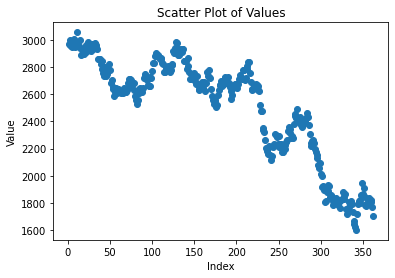

1601.7066283029499


In [17]:
eth_price_samples = create_stochastic_process(price_traj_type = 'concave')
eth_price_samples = [i for i in eth_price_samples] # ETH-USD pair
plot_price(eth_price_samples) 
print(min(eth_price_samples))

# Setup

In [18]:
constants = {
}

In [19]:
recent_staked = fetch_stake_data()
curr_stake_LRT = recent_staked[recent_staked['entity_category']=='Liquid Restaking']['amount_staked']
curr_stake_LST = recent_staked[recent_staked['entity_category']=='Liquid Staking']['amount_staked']
curr_stake_CEX = recent_staked[recent_staked['entity_category']=='CEXs']['amount_staked']
curr_stake_Solo = recent_staked[recent_staked['entity_category']=='Solo Stakers']['amount_staked']
curr_stake_SP = recent_staked[recent_staked['entity_category']=='Staking Pools']['amount_staked']
curr_stake_Unidentified = recent_staked[recent_staked['entity_category']=='Unidentified']['amount_staked']

In [20]:
recent_staked

,entity_category,amount_staked
0,CEXs,8.468447e+06
1,Liquid Restaking,2.823426e+06
2,Liquid Staking,1.106251e+07
3,Solo Stakers,3.402329e+05
4,Staking Pools,5.898599e+06
5,Unidentified,6.268803e+06


In [21]:
# Initialize an agent
cex_agent = CEXAgent(
    balance=curr_stake_CEX, 
    cnt=int(curr_stake_CEX/32), 
    category="CEX", 
    cost_APY= 0.0,
    # full_withdrawl=0.0, 
    # partial_withdrawl=0.0, 
    deposit_behavior=StandardDeposit(), 
    withdraw_behavior=StandardFullWithdraw(),
    entity="None"
)

lst_agent = LSTAgent(
    balance=curr_stake_LST, 
    cnt=int(curr_stake_LST/32), 
    category="LST", 
    cost_APY= 0.0,
    # full_withdrawl=0.0, 
    # partial_withdrawl=0.0, 
    deposit_behavior=StandardDeposit(), 
    withdraw_behavior=StandardFullWithdraw(),
    entity="None"
)

lrt_agent = LRTAgent(
    balance=curr_stake_LRT, 
    cnt=int(curr_stake_LRT/32), 
    category="LRT", 
    cost_APY= 0.0,
    # full_withdrawl=0.0, 
    # partial_withdrawl=0.0, 
    deposit_behavior=StandardDeposit(), 
    withdraw_behavior=StandardFullWithdraw(),
    entity="None"
)

solo_agent = SoloAgent(
    balance=curr_stake_Solo, 
    cnt=int(curr_stake_Solo/32), 
    category="Solo", 
    cost_APY= 0.0,
    # full_withdrawl=0.0, 
    # partial_withdrawl=0.0, 
    deposit_behavior=StandardDeposit(), 
    withdraw_behavior=StandardFullWithdraw(),
    entity="None"
)

sp_agent = StakingPoolAgent(
    balance=curr_stake_SP, 
    cnt=int(curr_stake_SP/32), 
    category="SP", 
    cost_APY= 0.0,
    # full_withdrawl=0.0, 
    # partial_withdrawl=0.0, 
    deposit_behavior=StandardDeposit(), 
    withdraw_behavior=StandardFullWithdraw(),
    entity="None"
)

etf_agent = ETFAgent(
    balance=0, 
    cnt=int(curr_stake_SP/32), 
    category="SP", 
    cost_APY= 0.0,
    # full_withdrawl=0.0, 
    # partial_withdrawl=0.0, 
    deposit_behavior=StandardDeposit(), 
    withdraw_behavior=StandardFullWithdraw(),
    entity="None"
)

<ipython-input-21-f3800099faa3>:4: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  cnt=int(curr_stake_CEX/32),
<ipython-input-21-f3800099faa3>:16: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  cnt=int(curr_stake_LST/32),
<ipython-input-21-f3800099faa3>:28: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  cnt=int(curr_stake_LRT/32),
<ipython-input-21-f3800099faa3>:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  cnt=int(curr_stake_Solo/32),
<ipython-input-21-f3800099faa3>:52: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  cnt

# Simulation

In [22]:
ETH_initial_price = eth_price_samples[0]


In [23]:
@dataclass
class MVIParams:

    eth_price_process:  List[Callable[[Run, Timestep], float]] = default(
        [lambda run, timestep: eth_price_samples[timestep]]
    )

    opportunity_cost: List[float] = default([0.02])

parameters = MVIParams().__dict__

In [24]:
psub = [{
    "policies": {
    },
    "variables": {
        "timestep": basic_model.update_timestep,
        "price": basic_model.update_price,
    }
},  { 
    "policies": {
        "action": agents_decision.deposit_withdraw
    },
    "variables": {
        "CEXAgent": agents_decision.update_CEXAgent_deposit_withdraw,
        "LSTAgent": agents_decision.update_LSTAgent_deposit_withdraw,
        "LRTAgent": agents_decision.update_LRTAgent_deposit_withdraw,
        "SoloAgent": agents_decision.update_SoloAgent_deposit_withdraw,
        "StakingPoolAgent": agents_decision.update_StakingPoolAgent_deposit_withdraw,
    }
},  { # TODO: double check the infra costs
    "policies": { 
        "action": infra_costs.calc_costs
    },
    "variables": {
        "CEXAgent": infra_costs.update_CEXAgent_cost,
        "LSTAgent": infra_costs.update_LSTAgent_cost,
        "LRTAgent": infra_costs.update_LRTAgent_cost,
        "SoloAgent": infra_costs.update_SoloAgent_cost,
        "StakingPoolAgent": infra_costs.update_StakingPoolAgent_cost,
    }
},  { 
    "policies": {
        "action": APY.calc_decentralization_and_total_staked
    },
    "variables": {
        "total_staked": APY.update_total_staked,
        "total_validator_cnt": APY.update_total_validator_cnt,
        "decentralization_metrics": APY.update_decentralization_metrics,
    }
}, { 
    "policies": {
        "action": APY.calc_issuance_APR
    },
    "variables": {
        "issuance_APR": APY.update_issuance_APR
    }
}, { 
    "policies": {
        "action": APY.calc_revenue_APY
    },
    "variables": {
        "revenue_APY": APY.update_revenue_APY,
        "revenue_APY_at_agent": APY.update_revenue_APY_at_agent
    }
}
]

initial_conditions = {
    "timestep": 0,
    "price": ETH_initial_price, 
    "CEXAgent": cex_agent,
    "LSTAgent": lst_agent,
    "LRTAgent": lrt_agent,
    "SoloAgent": solo_agent,
    "StakingPoolAgent": sp_agent,
    "ETFAgent": etf_agent,
    "total_staked": 0,
    "total_validator_cnt": 0,
    "decentralization_metrics": {},
    "issuance_APR": 0.0,
    "revenue_APY": 0.0,
    "revenue_APY_at_agent": {
        "CEXAgent": 0.0,
        "LSTAgent": 0.0,
        "LRTAgent": 0.0,
        "SoloAgent": 0.0,
        "StakingPoolAgent": 0.0
        }
}


params = parameters

model = Model(
        initial_state=initial_conditions,
        state_update_blocks=psub,
        params=params,
    )

In [25]:
simulation = Simulation(model=model, timesteps=100, runs=1)
experiment = Experiment([simulation])
experiment.engine = Engine(deepcopy=False, backend=Backend.SINGLE_PROCESS)
results = experiment.run()
df = pd.DataFrame(results)

2024-10-29 14:41:12,326 INFO root Starting simulation 0 / run 0 / subset 0


In [26]:
df

,timestep,price,CEXAgent,LSTAgent,LRTAgent,SoloAgent,StakingPoolAgent,ETFAgent,total_staked,total_validator_cnt,decentralization_metrics,issuance_APR,revenue_APY,revenue_APY_at_agent,simulation,subset,run,substep
0,0,2966.014139,CEXAgent(balance=0 8.774546e+06\nName: amou...,LSTAgent(balance=2 1.129287e+07\nName: amou...,LRTAgent(balance=1 3.185756e+06\nName: amou...,SoloAgent(balance=3 343814.647628\nName: am...,StakingPoolAgent(balance=4 6.240050e+06\nNa...,"ETFAgent(balance=0, cnt=184331, category='SP',...",0.000000e+00,0.000000e+00,{},0.000000,0.000000,"{'CEXAgent': 0.0, 'LSTAgent': 0.0, 'LRTAgent':...",0,0,1,0
1,1,2966.014139,CEXAgent(balance=0 8.774546e+06\nName: amou...,LSTAgent(balance=2 1.129287e+07\nName: amou...,LRTAgent(balance=1 3.185756e+06\nName: amou...,SoloAgent(balance=3 343814.647628\nName: am...,StakingPoolAgent(balance=4 6.240050e+06\nNa...,"ETFAgent(balance=0, cnt=184331, category='SP',...",0.000000e+00,0.000000e+00,{},0.000000,0.000000,"{'CEXAgent': 0.0, 'LSTAgent': 0.0, 'LRTAgent':...",0,0,1,1
2,1,2966.014139,CEXAgent(balance=0 8.774546e+06\nName: amou...,LSTAgent(balance=2 1.129287e+07\nName: amou...,LRTAgent(balance=1 3.185756e+06\nName: amou...,SoloAgent(balance=3 343814.647628\nName: am...,StakingPoolAgent(balance=4 6.240050e+06\nNa...,"ETFAgent(balance=0, cnt=184331, category='SP',...",0.000000e+00,0.000000e+00,{},0.000000,0.000000,"{'CEXAgent': 0.0, 'LSTAgent': 0.0, 'LRTAgent':...",0,0,1,2
3,1,2966.014139,CEXAgent(balance=0 8.774546e+06\nName: amou...,LSTAgent(balance=2 1.129287e+07\nName: amou...,LRTAgent(balance=1 3.185756e+06\nName: amou...,SoloAgent(balance=3 343814.647628\nName: am...,StakingPoolAgent(balance=4 6.240050e+06\nNa...,"ETFAgent(balance=0, cnt=184331, category='SP',...",0.000000e+00,0.000000e+00,{},0.000000,0.000000,"{'CEXAgent': 0.0, 'LSTAgent': 0.0, 'LRTAgent':...",0,0,1,3
4,1,2966.014139,CEXAgent(balance=0 8.774546e+06\nName: amou...,LSTAgent(balance=2 1.129287e+07\nName: amou...,LRTAgent(balance=1 3.185756e+06\nName: amou...,SoloAgent(balance=3 343814.647628\nName: am...,StakingPoolAgent(balance=4 6.240050e+06\nNa...,"ETFAgent(balance=0, cnt=184331, category='SP',...",3.450704e+07,1.078345e+06,"{'HHI': 0.22838685441040774, 'CR_k': 0.7371983...",0.000000,0.000000,"{'CEXAgent': 0.0, 'LSTAgent': 0.0, 'LRTAgent':...",0,0,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
596,100,2766.764286,CEXAgent(balance=0 8.774546e+06\nName: amou...,LSTAgent(balance=2 1.129287e+07\nName: amou...,LRTAgent(balance=1 3.185756e+06\nName: amou...,SoloAgent(balance=3 343814.647628\nName: am...,StakingPoolAgent(balance=4 6.240050e+06\nNa...,"ETFAgent(balance=0, cnt=184331, category='SP',...",3.572027e+07,1.116258e+06,"{'HHI': 0.22597310112628013, 'CR_k': 0.7362285...",0.027829,-0.013251,"{'CEXAgent': -0.016239231239398914, 'LSTAgent'...",0,0,1,2
597,100,2766.764286,CEXAgent(balance=0 8.774546e+06\nName: amou...,LSTAgent(balance=2 1.129287e+07\nName: amou...,LRTAgent(balance=1 3.185756e+06\nName: amou...,SoloAgent(balance=3 343814.647628\nName: am...,StakingPoolAgent(balance=4 6.240050e+06\nNa...,"ETFAgent(balance=0, cnt=184331, category='SP',...",3.572027e+07,1.116258e+06,"{'HHI': 0.22597310112628013, 'CR_k': 0.7362285...",0.027829,-0.013251,"{'CEXAgent': -0.016239231239398914, 'LSTAgent'...",0,0,1,3
598,100,2766.764286,CEXAgent(balance=0 8.774546e+06\nName: amou...,LSTAgent(balance=2 1.129287e+07\nName: amou...,LRTAgent(balance=1 3.185756e+06\nName: amou...,SoloAgent(balance=3 343814.647628\nName: am...,StakingPoolAgent(balance=4 6.240050e+06\nNa...,"ETFAgent(balance=0, cnt=184331, category='SP',...",3.573557e+07,1.116736e+06,"{'HHI': 0.2259299394168811, 'CR_k': 0.73616894...",0.027829,-0.013251,"{'CEXAgent': -0.016239231239398914, 'LSTAgent'...",0,0,1,4
599,100,2766.764286,CEXAgent(balance=0 8.774546e+06\nName: amou...,LSTAgent(balance=2 1.129287e+07\nName: amou...,LRTAgent(balance=1 3.185756e+06\nName: amou...,SoloAgent(balance=3 343814.647628\nName: am...,StakingPoolA

In [27]:
visualizations.plot_token_price_per_subset(
    df,
    scenario_names={
    0: "normal",
}
)

In [28]:
visualizations.plot_total_staked(
    df,
    scenario_names={
    0: "normal",
}
)

In [29]:
visualizations.plot_hhi(
    df,
    scenario_names={
    0: "normal",
}
)